# Quiz -Interpolación 22 de agosto de 2018

## Nombre: Johan Smith Agudelo Rodriguez y Gabriel Jaime Thomas Uribe

Se ha recibido la siguiente imagen y se le ha encomendado eliminar el color rosa de la mitad (a la persona que se lo envío no le gusta ese color). La idea es cambiar dicho color por una combinación de los colores del centro y de la parte exterior usando una técnica de interpolación, bajo las siguientes condiciones:

1. La técnica de interpolación (Lagrange o Newton) debe ser implementada por usted, no se pueden utilizar funciones de interpolación de alguna librería pre-existente de python.
2. En la técnica se deben utilizar píxeles del círculo exterior **Y** del círculo interior como vecinos (**ambos**).
3. El orden del polinomio debe ser libre de elegir en un rango de 3 a 8 (**el usuario debe poder elegir cualquier valor en ese rango**)
4. Todo debe estar **completamente** comentado, de tal forma que el código se pueda explicar **SOLO** con los comentarios
5. No cambie el nombre del notebook, pero recuerde poner su **Nombre** en la parte superior.

![Imagen](Imagen_Quiz.png)

RUNNING


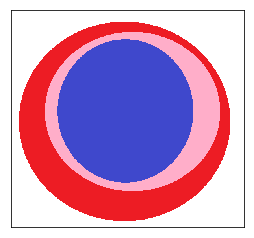

Ingrese un grado entre 3 y 8: 3


END


In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt #cargamos la librería matplotlib
from functools import reduce
import operator

# abre una imagen
def openImg(img_file):
    return cv2.imread(img_file, 1)

# imprime una imagen
def printImg(img):
    b,g,r = cv2.split(img) 
    img = cv2.merge((r,g,b))
    plt.xticks([]), plt.yticks([])
    plt.imshow(img)
    plt.show()


##
# Para un polinomio de grado _n_ se necesitan (_n_ + 1) puntos
# return: La funcion P(X) para el conjunto de xs, y ys
def lagrange(xs, ys):
    obj = lambda: None
    
    def P(X):
        assert len(xs) == len(ys), 'len xs <> len ys'
        n = len(xs)
        
        def production(k):
            operands = [(X - xs[i]) / (xs[k] - xs[i]) for i in range(n) if k != i]
            return reduce(operator.mul, operands)
        
        t = sum(production(k) * ys[k] for k in range(n))
        return t

    obj.P = P
    return obj

# 2. En la técnica se deben utilizar píxeles del círculo exterior **Y** del círculo interior como vecinos (**ambos**).

# verifica si el pixel es rosado con un nivel de tolerancia (diferentes tonos de rosado)
def isPink(pixel):
    pink = [201, 174, 255]
    b,g,r = pixel
    return abs(b - pink[0]) < 10 and abs(g - pink[1]) < 10 and abs(r - pink[2]) < 10

# verifica si el pixel es azul
def isBlue(pixel):
    return list(pixel) == [204, 72, 63]

# verifica si el pixel es rojo
def isRed(pixel):
    return list(pixel) == [36, 28, 237]

# busca una fila azul o rojo cercano por encima del pixel rosado 
def findTop(img, x, y):
    for i in range(x, 0, -1):
        if isBlue(img[i, y]) or isRed(img[i, y]):
            return i

# busca una fila azul o rojo cercano por debajo del pixel rosado 
def findBottom(img, x, y):
    for i in range(x, height, 1):
        if isBlue(img[i, y]) or isRed(img[i, y]):
            return i

# busca una columna azul o rojo cercano por la izquierda del pixel rosado 
def findLeft(img, x, y):
    for j in range(y, 0, -1):
        if isBlue(img[x, j]) or isRed(img[x, j]):
            return j
        
# busca una columna azul o rojo cercano por la derecha del pixel rosado 
def findRight(img, x, y):
    for j in range(y, width, 1):
        if isBlue(img[x, j]) or isRed(img[x, j]):
            return j

        
img = openImg('./Imagen_Quiz.png')
width = int(img.shape[1]) # width
height = int(img.shape[0]) # height

# toma los datos y realiza la interpolacion con lagrange
def interpolate(img, degree):
    for i in range(height):
        for j in range(width):
            pixel = img[i, j]
            
            # filtramos los pixeles rosados
            if isPink(pixel):
                # buscar vecinos en eje Y
                # ys_bgr: es una array de vecinos de tuplas de 'indices' y un pixel bgr (indice, [b, g, r])
                ys_bgr = []
                
                # Sera el valor 'i' o 'j' a interpolar
                X = 0                
                near_top = findTop(img, i, j)
                near_bottom = findBottom(img, i, j)
                
                # Interpolacion: Vertical
                if list(img[near_top, j]) != list(img[near_bottom, j]): # Verifica si los vecinos son de diferente color
                    X = i
                    # forma el conjunto de pixeles vecinos por encima del rosado
                    for near_index in range(near_top, max(near_top - degree // 2, 0), -1):
                        near_pixel = img[near_index, j]
                        ys_bgr = ys_bgr + [(near_index, near_pixel)]
                    
                    # forma el conjunto de pixeles vecinos por debajo del rosado
                    for near_index in range(near_bottom, min(near_bottom + degree // 2, height), 1):
                        near_pixel = img[near_index, j]
                        ys_bgr =  [(near_index, near_pixel)] + ys_bgr
                
                # Interpolacion: Horizontal 
                else: #Vecinos de igual color, entonces interpolación horizontal
                    X = j
                    near_left = findLeft(img, i, j)
                    near_right = findRight(img, i, j)
                    # forma el conjunto de pixeles vecinos por la izquierda del rosado
                    for near_index in range(near_left, max(near_left - degree // 2, 0), -1):
                        near_pixel = img[i, near_index]
                        ys_bgr = ys_bgr + [(near_index, near_pixel)]
                    
                    # forma el conjunto de pixeles vecinos por la derecha del rosado
                    for near_index in range(near_right, min(near_right + degree // 2, width), 1):
                        near_pixel = img[i, near_index]
                        ys_bgr = [(near_index, near_pixel)] + ys_bgr
                
                # ys: Conjunto indices
                ys = list(map(lambda i: i[0], ys_bgr))
                
                # xs: Conjunto de colores b, g, r
                bxs = list(map(lambda i: i[1][0], ys_bgr))
                gxs = list(map(lambda i: i[1][1], ys_bgr))
                rxs = list(map(lambda i: i[1][2], ys_bgr))
                
                # interpola los pixeles rosados con lagrange
                b = int(lagrange(ys, bxs).P(X))
                g = int(lagrange(ys, gxs).P(X))
                r = int(lagrange(ys, rxs).P(X))
                
                # modifica el pixel rosado
                img.itemset((i, j, 0), int(b))
                img.itemset((i, j, 1), int(g))
                img.itemset((i, j, 2), int(r))
                
              
print('RUNNING')
printImg(img)
degree = input('Ingrese un grado entre 3 y 8: ')
interpolate(img, int(degree))
printImg(img)
cv2.imwrite('Image_Quiz_interpolate.png', img)

print('END')